In [45]:
from tracr.rasp import rasp
from tracr.compiler import compiling
from tracr.compiler import lib

import sys
import os
import numpy as np
import jax.numpy as jnp

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path+"\\src")

from Model import Model
from functions import *

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
def saveArray(array, fileName="temp"):
    file = open(fileName, "wb")
    np.save(file, array)
    file.close()

def loadArray(fileNames="temp"):
    if type(fileNames) is list:
        file = open(fileNames[0], "rb")
        array = np.load(file)
        file.close()
        for fn in fileNames[1:]:
            file = open(fn, "rb")
            conAcc = np.load(file)
            array = np.concatenate((array, conAcc), axis=1)
            file.close()
        
    else:
        file = open(fileNames, "rb")
        array = np.load(file)
        file.close()

    return array

### Generate Training Data and Model

In [6]:
maxLength = 5
name = "sort"
N = 5000

model = generateModel(name, maxLength)

np.random.seed(666)
data = generateData(name, maxLength, N)
split = int(len(data) * 0.90)
data_train, data_test = data[:split], data[split:]
split = int(len(data_train) * 0.85)
data_train, data_val = data_train[:split], data_train[split:]
X, Y = encodeAndPadData(data, model.raspFunction, model.inputs, maxLength)

#Split data
split = int(X.shape[0] * 0.90)
X_train, X_test = X[:split], X[split:]
Y_train, Y_test = Y[:split], Y[split:]

split = int(X_train.shape[0] * 0.85)
X_train, X_val = X_train[:split], X_train[split:]
Y_train, Y_val = Y_train[:split], Y_train[split:]

print(X_train[:5])
print(Y_train[:5])

print(X_train.shape, X_val.shape, X_test.shape)
print(Y_train.shape, Y_val.shape, Y_test.shape)
print(len(data_train), len(data_val), len(data_test))

[[6 2 5 7 7 7]
 [6 1 4 5 3 7]
 [6 3 4 4 1 7]
 [6 0 0 5 2 4]
 [6 5 5 5 4 3]]
[[0 2 5 0 0 0]
 [0 1 3 4 5 0]
 [0 1 3 4 4 0]
 [0 0 0 2 4 5]
 [0 3 4 5 5 5]]
(3825, 6) (675, 6) (500, 6)
(3825, 6) (675, 6) (500, 6)
3825 675 500


In [80]:
#Function which compares two encoded data sets to check for uniqueness and overlap in the data
def dataUniqueness(X_first, X_second, dataSetNames = ("First", "Second")):
    firstUnique = jnp.unique(X_first, axis=0)
    print("%s data set has %d unique elements, equivalent to %.1f%%" % (dataSetNames[0], len(firstUnique),100* len(firstUnique)/len(X_first)))
    secondUnique = jnp.unique(X_second, axis=0)
    print("%s data set has %d unique elements, equivalent to %.1f%%" % (dataSetNames[1], len(secondUnique),100* len(secondUnique)/len(X_second)))

    hitCount = 0
    for x in X_second:
        if jnp.equal(firstUnique, x).all(1).any():
            hitCount+=1

    print("%s data set shares %d elements with %s data set meaning %.1f%% of data is unique" % (dataSetNames[1], hitCount, dataSetNames[0], 100- 100*hitCount/len(X_second)))

dataUniqueness(X_train, X_val, ("Training", "Validation"))

#These findings suggest a bug in my remove duplicates during creation

Training data set has 276 unique elements, equivalent to 7.2%
Validation data set has 127 unique elements, equivalent to 18.8%
Validation data set shares 667 elements with Training data set meaning 1.2% of data is unique


### Train for a Large Number of Epochs

100%|██████████| 500/500 [03:54<00:00,  2.13it/s]


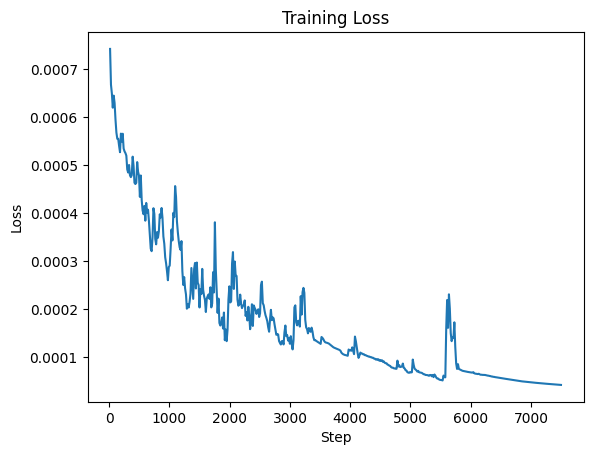

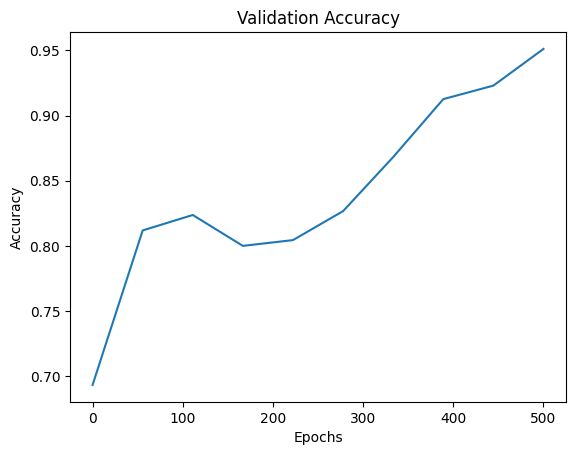

In [7]:
model.resetWeights()

metrics, validations = model.train(X_train, Y_train, n_epochs=500, batch_size=256, lr=1e-4, plot=True, X_val=X_val, Y_val=Y_val, valStep=50)

### Save Resutls

500 [0.00074283 0.00066816 0.00064987 0.00062045 0.00064551] 0.00017334925796562515
10 [0.69333333 0.81185185 0.8237037  0.8        0.80444444] 0.8414814814814815


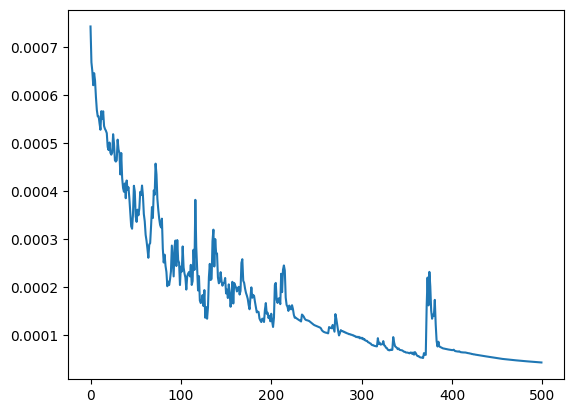

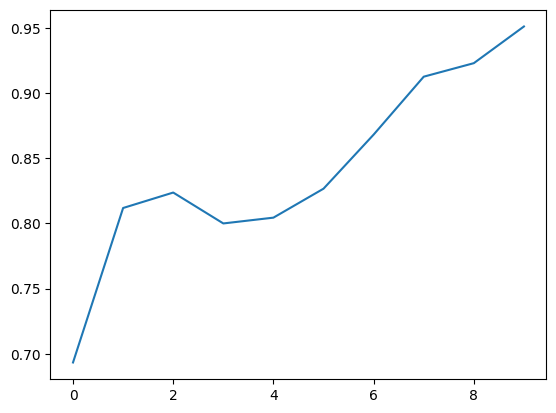

In [8]:
saveDirectory = "savedData/overTraining/"

#Save loss and validation accuracy
saveArray([m["loss"] for m in metrics], saveDirectory + "temp_loss")
saveArray(validations, saveDirectory + "temp_val")

#Load the saved array from disk
loss = loadArray(saveDirectory + "temp_loss")
val = loadArray(saveDirectory + "temp_val")

print(len(loss), loss[:5], np.mean(loss))
plt.plot(loss)

plt.figure()
print(len(val), val[:5], np.mean(val))
plt.plot(val)

## Show Results

All models were tested with maxLen=5, N=5000, batch_size=256, lr=1e-4, n_epochs=50000 and valStep=50. 
Training data 90% of data set and validation data 15% of training data.

NOTE: The dyck2 model was tested in segments of 5000 epochs which causes some differences from a clean run due to the adam optimizer

#### Data uniqueness for the following tests
Sort: 
Training data set has 1881 unique elements, equivalent to 49.2%.
Validation data set has 483 unique elements, equivalent to 71.6%.
Validation data set shares 429 elements with Training data set meaning 36.4% of data is unique.

Hist: 
Training data set has 936 unique elements, equivalent to 24.5%.
Validation data set has 359 unique elements, equivalent to 53.2%.
Validation data set shares 598 elements with Training data set meaning 11.4% of data is unique.

Reverse:
Training data set has 1449 unique elements, equivalent to 37.9%.
Validation data set has 424 unique elements, equivalent to 62.8%.
Validation data set shares 536 elements with Training data set meaning 20.6% of data is unique.

Most-freq:
Training data set has 1449 unique elements, equivalent to 37.9%.
Validation data set has 424 unique elements, equivalent to 62.8%.
Validation data set shares 536 elements with Training data set meaning 20.6% of data is unique.
NOTE does not use the same data as reverse but is encoded with the same amount of tokens in the same manners which means one can be mapped to the other if so desired.

Dyck1:
Training data set has 48 unique elements, equivalent to 1.3%.
Validation data set has 37 unique elements, equivalent to 5.5%.
Validation data set shares 675 elements with Training data set meaning 0.0% of data is unique. NOTE Atrociously shallow data set

Dyck2:
Training data set has 276 unique elements, equivalent to 7.2%.
Validation data set has 127 unique elements, equivalent to 18.8%.
Validation data set shares 667 elements with Training data set meaning 1.2% of data is unique.

Suggestions to improve uniqueness in data generation
  * Use a longer max length
  * Allow more unique input tokens
  * Generate until a certain amount of unique data points have been generated
  * (For small sets with short maxLength it is possible to generate all possible combinations instead of randomly generating)

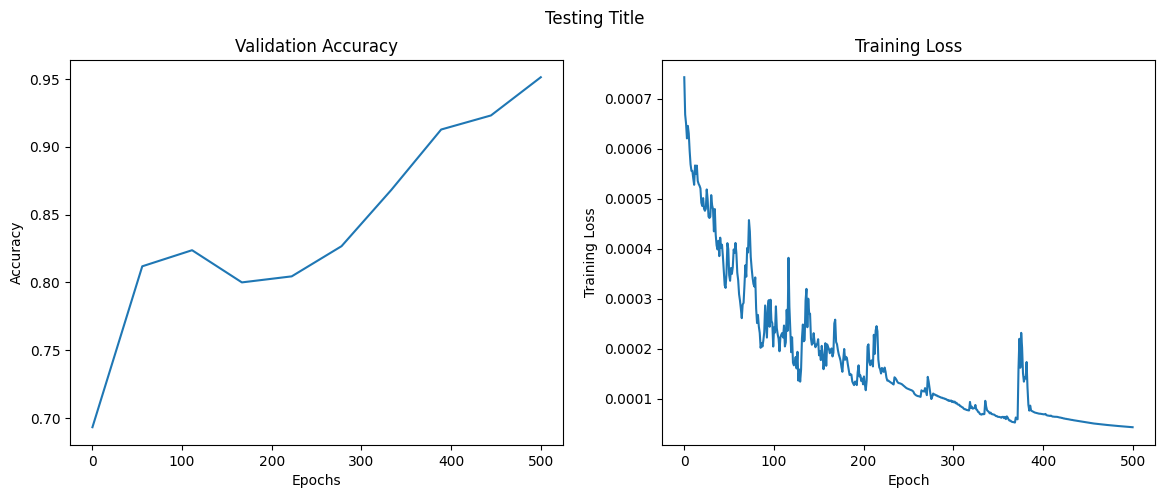

In [30]:
def displayResults(title = "Base Title", baseDirectory = "savedData/overTraining/", valName = "temp_val", lossName = "temp_loss", n_epochs = 50000):
    #Plot validation accuracies
    val = loadArray(baseDirectory + valName)
    fig, axs = plt.subplots(1,2,figsize=(14,5))
    fig.suptitle(title)
    axs[0].plot(np.linspace(0, n_epochs, len(val)), [m for m in val])
    axs[0].set(xlabel='Epochs', ylabel="Accuracy")
    axs[0].set_title('Validation Accuracy')

    # plot the loss values
    loss = loadArray(baseDirectory + lossName)
    axs[1].plot(np.linspace(0, n_epochs, len(loss)), [m for m in loss])
    axs[1].set(xlabel='Epoch', ylabel="Training Loss")
    axs[1].set_title('Training Loss')
    return

#Display dummy result
displayResults(title = "Testing Title", n_epochs=500)

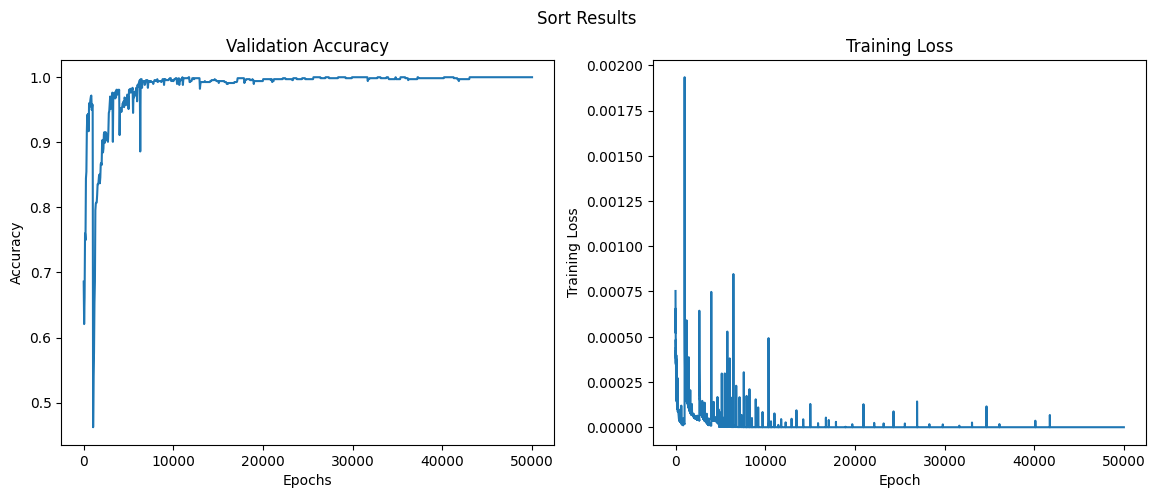

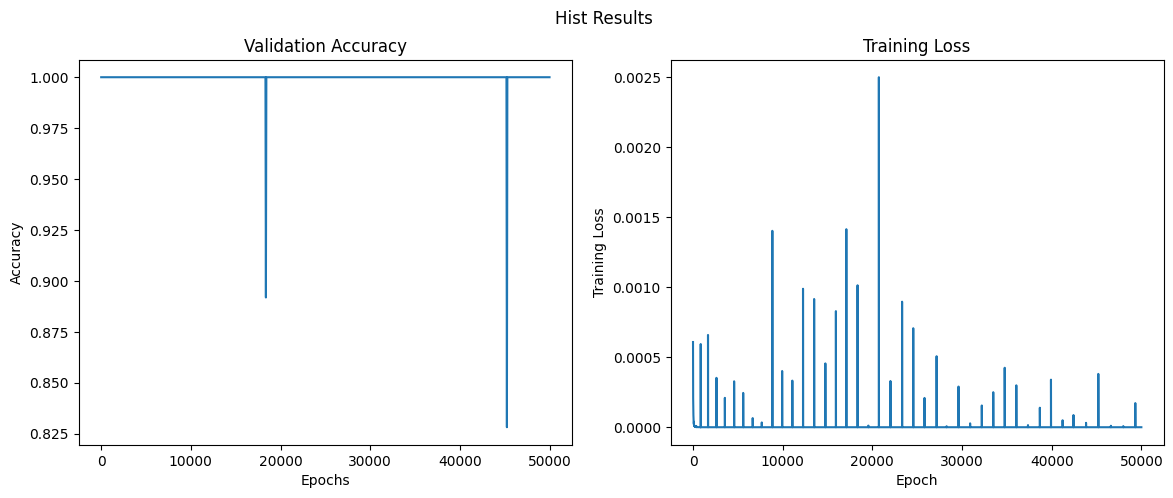

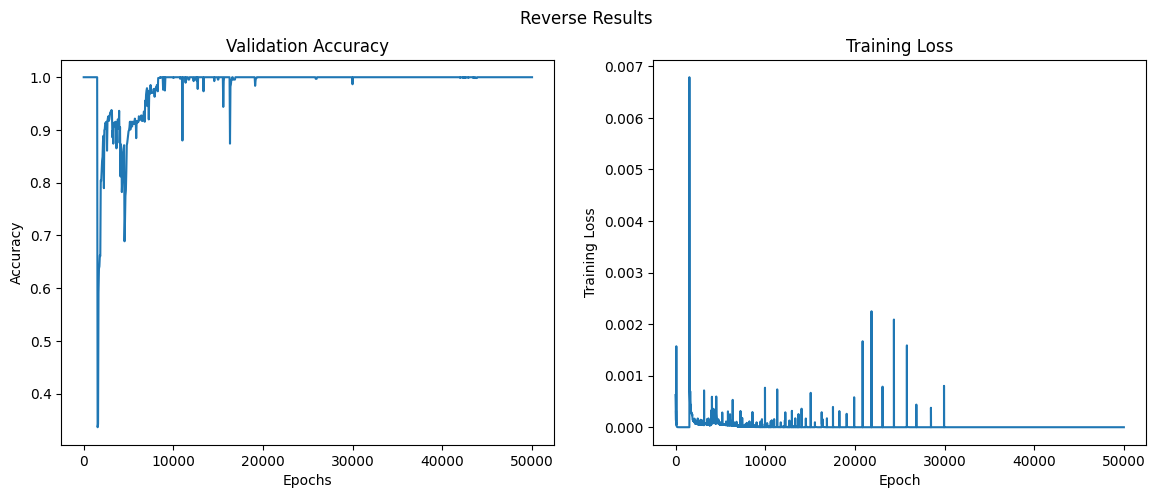

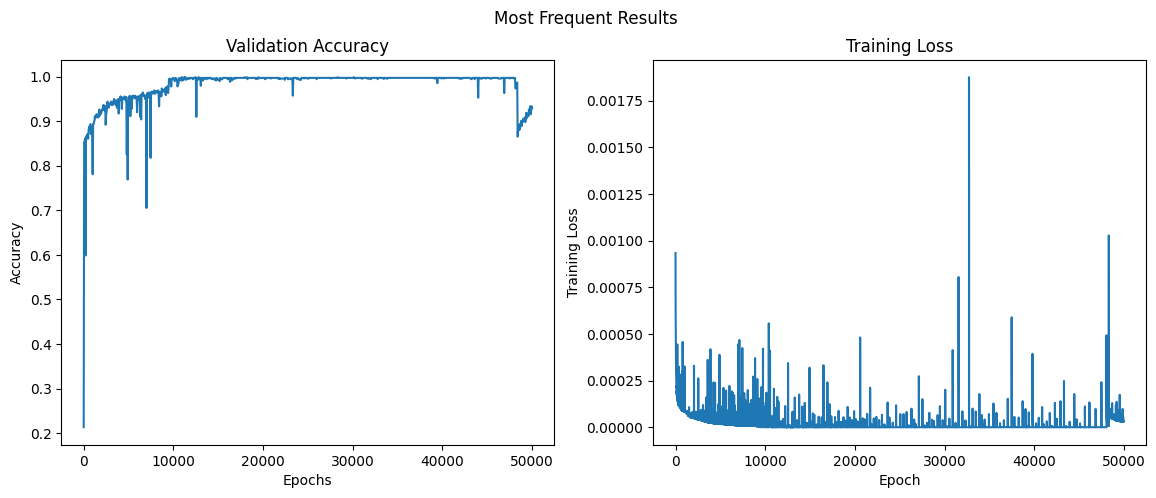

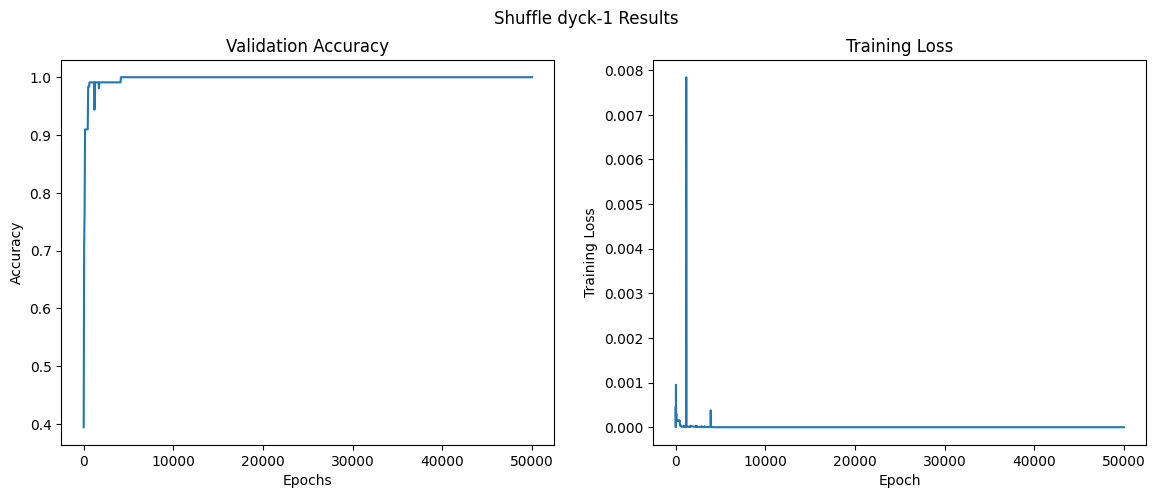

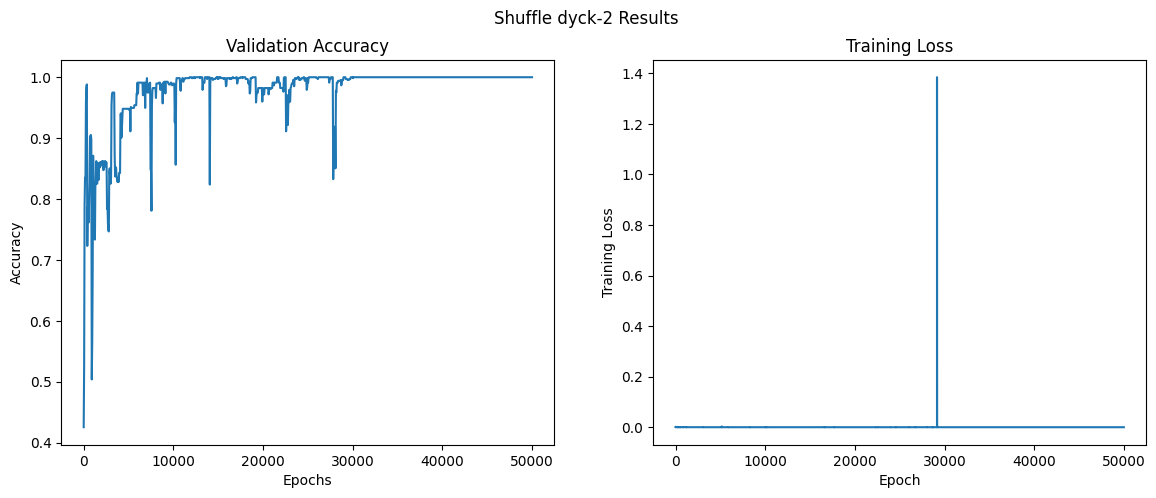

In [34]:
displayResults(title="Sort Results", valName="sort_val", lossName="sort_loss")
displayResults(title="Hist Results", valName="hist_val", lossName="hist_loss")
displayResults(title="Reverse Results", valName="reverse_val", lossName="reverse_loss")
displayResults(title="Most Frequent Results", valName="mostFreq_val", lossName="mostFreq_loss")
displayResults(title="Shuffle dyck-1 Results", valName="dyck1_val", lossName="dyck1_loss")
displayResults(title="Shuffle dyck-2 Results", valName="dyck2_val", lossName="dyck2_loss")

## Soft testing with unique data

Better uniqueness is achieved through using max length 10 instead of 5 and removing all duplicates before training begins.

Also only splits the data into a train and validation set since the test set was unused for this test. Now use 85% as train data and 15% as validation data.

In [137]:
maxLength = 10
name = "reverse"
N = 5000

model = generateModel(name, maxLength)

np.random.seed(666)
data = generateData(name, maxLength, N, True)
split = int(len(data) * 0.85)
data_train, data_val = data[:split], data[split:]
X, Y = encodeAndPadData(data, model.raspFunction, model.inputs, maxLength)

#Split data
split = int(X.shape[0] * 0.85)
X_train, X_val = X[:split], X[split:]
Y_train, Y_val = Y[:split], Y[split:]

print(X_train[:5])
print(Y_train[:5])

print(X_train.shape, X_val.shape)
print(Y_train.shape, Y_val.shape)
print(len(data_train), len(data_val))
print("Total samples", len(data))

[[0 2 6 5 5 4 4 4 4 4 4]
 [0 1 1 3 4 4 4 4 4 4 4]
 [0 6 5 1 6 6 1 1 4 4 4]
 [0 3 1 6 3 3 2 4 4 4 4]
 [0 1 5 4 4 4 4 4 4 4 4]]
[[0 3 3 4 1 0 0 0 0 0 0]
 [0 2 0 0 0 0 0 0 0 0 0]
 [0 0 0 4 4 0 3 4 0 0 0]
 [0 1 2 2 4 0 2 0 0 0 0]
 [0 3 0 0 0 0 0 0 0 0 0]]
(3230, 11) (571, 11)
(3230, 11) (571, 11)
3230 571
Total samples 3801


In [139]:
dataUniqueness(X_train, X_val, ("Training", "Validation"))

Training data set has 3230 unique elements, equivalent to 100.0%
Validation data set has 571 unique elements, equivalent to 100.0%
Validation data set shares 0 elements with Training data set meaning 100.0% of data is unique


100%|██████████| 50000/50000 [14:25:10<00:00,  1.04s/it]   


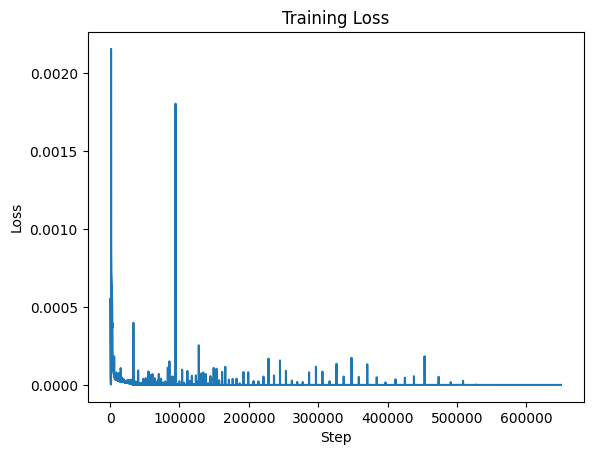

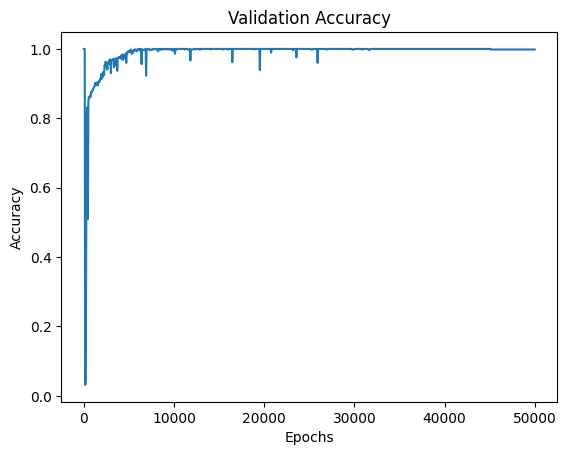

In [140]:
model.resetWeights()

metrics, validations = model.train(X_train, Y_train, n_epochs=50000, batch_size=256, lr=1e-4, plot=True, X_val=X_val, Y_val=Y_val, valStep=50)

In [141]:
saveDirectory = "savedData/overTraining/"

#Save loss and validation accuracy
saveArray([m["loss"] for m in metrics], saveDirectory + "reverse_loss_v2")
saveArray(validations, saveDirectory + "reverse_val_v2")

## Temporary Grid Searching

In [168]:
maxLength = 10
name = "hist"
N = 2000

model = generateModel(name, maxLength)

np.random.seed(666)
data = generateData(name, maxLength, N, True)
split = int(len(data) * 0.85)
data_train, data_val = data[:split], data[split:]
X, Y = encodeAndPadData(data, model.raspFunction, model.inputs, maxLength)

#Split data
split = int(X.shape[0] * 0.85)
X_train, X_val = X[:split], X[split:]
Y_train, Y_val = Y[:split], Y[split:]

print(X_train[:5])
print(Y_train[:5])

print(X_train.shape, X_val.shape)
print(Y_train.shape, Y_val.shape)
print(len(data_train), len(data_val))
print("Total samples", len(data))

[[0 2 3 3 3 4 4 4 4 4 4]
 [0 2 5 3 5 1 5 4 4 4 4]
 [0 5 1 3 4 4 4 4 4 4 4]
 [0 5 2 3 1 5 2 2 2 1 5]
 [0 1 1 1 1 1 3 3 3 5 1]]
[[0 1 3 3 3 0 0 0 0 0 0]
 [0 1 3 1 3 1 3 0 0 0 0]
 [0 1 1 1 0 0 0 0 0 0 0]
 [0 3 4 1 2 3 4 4 4 2 3]
 [0 6 6 6 6 6 3 3 3 1 6]]
(1280, 11) (226, 11)
(1280, 11) (226, 11)
1280 226
Total samples 1506


In [170]:
model.setJaxPRNGKey(666)

n_epochs_values = [2000]
batch_size_values = [128, 256, 512]
learning_rate_values = [1e-5, 3e-5, 1e-04, 3e-4]

model.gridSearch(X_train, Y_train, X_val, Y_val, n_epochs_values, batch_size_values, learning_rate_values, averageCount=3)

100%|██████████| 2000/2000 [01:14<00:00, 26.88it/s]

    n_epochs  batch_size  learning_rate  Gaussian_mean  Gaussian_std  accuracy_mean  accuracy_std
0       2000         128        0.00001              0             1       0.004425      0.003613
1       2000         128        0.00003              0             1       0.000000      0.000000
2       2000         128        0.00010              0             1       0.005900      0.002086
3       2000         128        0.00030              0             1       0.004425      0.003613
4       2000         256        0.00001              0             1       0.000000      0.000000
5       2000         256        0.00003              0             1       0.000000      0.000000
6       2000         256        0.00010              0             1       0.007375      0.005519
7       2000         256        0.00030              0             1       0.008850      0.009559
8       2000         512        0.00001              0             1       0.000000      0.000000
9       2000        

In [ ]:
"""

Sort results:
N = 2000, remove duplicates, 15% test data
    n_epochs  batch_size  learning_rate  Gaussian_mean  Gaussian_std  accuracy_mean  accuracy_std
0        500         128        0.00001              0             1       0.001318      0.001863
1        500         128        0.00003              0             1       0.001318      0.001863
2        500         128        0.00010              0             1       0.000000      0.000000
3        500         128        0.00030              0             1       0.000000      0.000000
4        500         256        0.00001              0             1       0.000000      0.000000
5        500         256        0.00003              0             1       0.002635      0.001863
6        500         256        0.00010              0             1       0.001318      0.001863
7        500         256        0.00030              0             1       0.000000      0.000000
8        500         512        0.00001              0             1       0.000000      0.000000
9        500         512        0.00003              0             1       0.001318      0.001863
10       500         512        0.00010              0             1       0.000000      0.000000
11       500         512        0.00030              0             1       0.002635      0.001863

Hist results:
N = 2000, remove duplicates, 15% test data
    n_epochs  batch_size  learning_rate  Gaussian_mean  Gaussian_std  accuracy_mean  accuracy_std
0       2000         128        0.00001              0             1       0.004425      0.003613
1       2000         128        0.00003              0             1       0.000000      0.000000
2       2000         128        0.00010              0             1       0.005900      0.002086
3       2000         128        0.00030              0             1       0.004425      0.003613
4       2000         256        0.00001              0             1       0.000000      0.000000
5       2000         256        0.00003              0             1       0.000000      0.000000
6       2000         256        0.00010              0             1       0.007375      0.005519
7       2000         256        0.00030              0             1       0.008850      0.009559
8       2000         512        0.00001              0             1       0.000000      0.000000
9       2000         512        0.00003              0             1       0.000000      0.000000
10      2000         512        0.00010              0             1       0.002950      0.004172
11      2000         512        0.00030              0             1       0.001475      0.002086
"""

## Overtraining on Random Weights

In [179]:
maxLength = 10
name = "sort"
N = 5000

model = generateModel(name, maxLength)

np.random.seed(666)
data = generateData(name, maxLength, N, True)
split = int(len(data) * 0.85)
data_train, data_val = data[:split], data[split:]
X, Y = encodeAndPadData(data, model.raspFunction, model.inputs, maxLength)

#Split data
split = int(X.shape[0] * 0.85)
X_train, X_val = X[:split], X[split:]
Y_train, Y_val = Y[:split], Y[split:]

print(X_train[:5])
print(Y_train[:5])

print(X_train.shape, X_val.shape)
print(Y_train.shape, Y_val.shape)
print(len(data_train), len(data_val))
print("Total samples", len(data))

[[6 5 1 4 5 7 7 7 7 7 7]
 [6 4 4 1 0 0 7 7 7 7 7]
 [6 5 2 4 5 5 5 4 3 0 7]
 [6 4 0 0 4 2 0 7 7 7 7]
 [6 2 5 2 5 1 0 7 7 7 7]]
[[0 1 4 5 5 0 0 0 0 0 0]
 [0 0 0 1 4 4 0 0 0 0 0]
 [0 0 2 3 4 4 5 5 5 5 0]
 [0 0 0 0 2 4 4 0 0 0 0]
 [0 0 1 2 2 5 5 0 0 0 0]]
(3383, 11) (598, 11)
(3383, 11) (598, 11)
3383 598
Total samples 3981


100%|██████████| 4000/4000 [1:13:44<00:00,  1.11s/it]


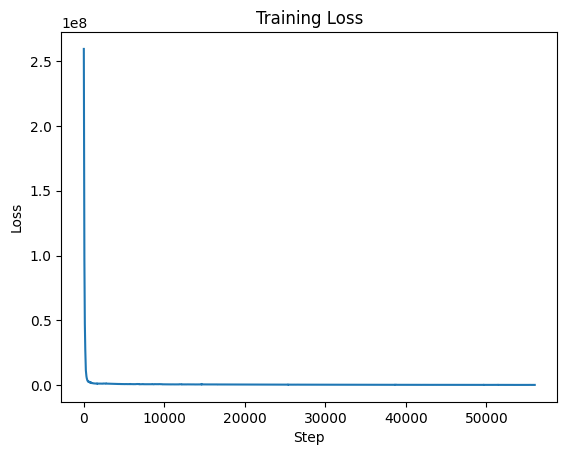

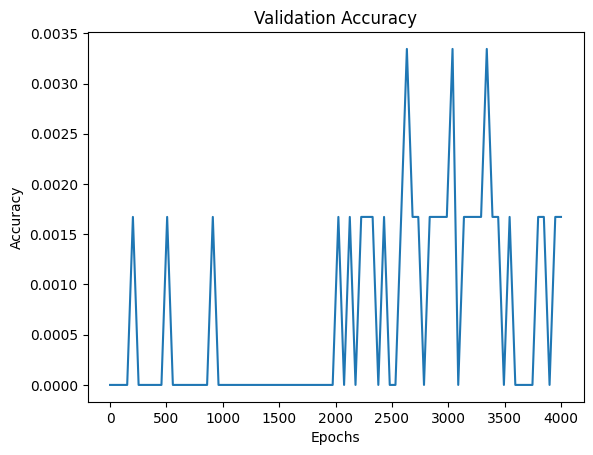

In [182]:
model.setRandomWeights()
metrics, validations = model.train(X_train, Y_train, n_epochs=4000, batch_size=256, lr=1e-4, plot=True, X_val=X_val, Y_val=Y_val, valStep=50)

In [183]:
saveDirectory = "savedData/overTraining/"

#Save loss and validation accuracy
saveArray([m["loss"] for m in metrics], saveDirectory + "short_random_sort_loss_v2")
saveArray(validations, saveDirectory + "short_random_sort_val_v2")

#### Comparing random start with Tracr model start

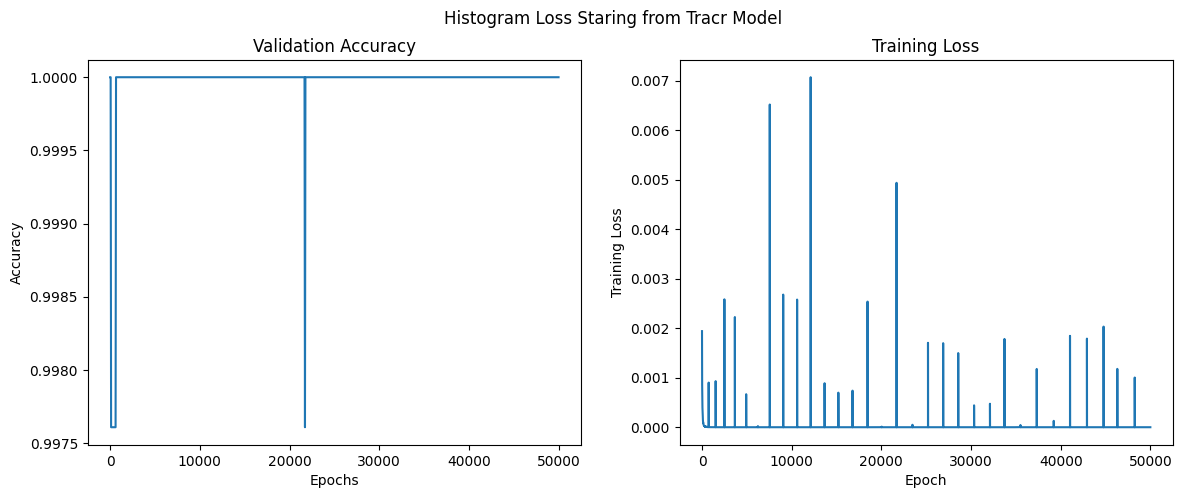

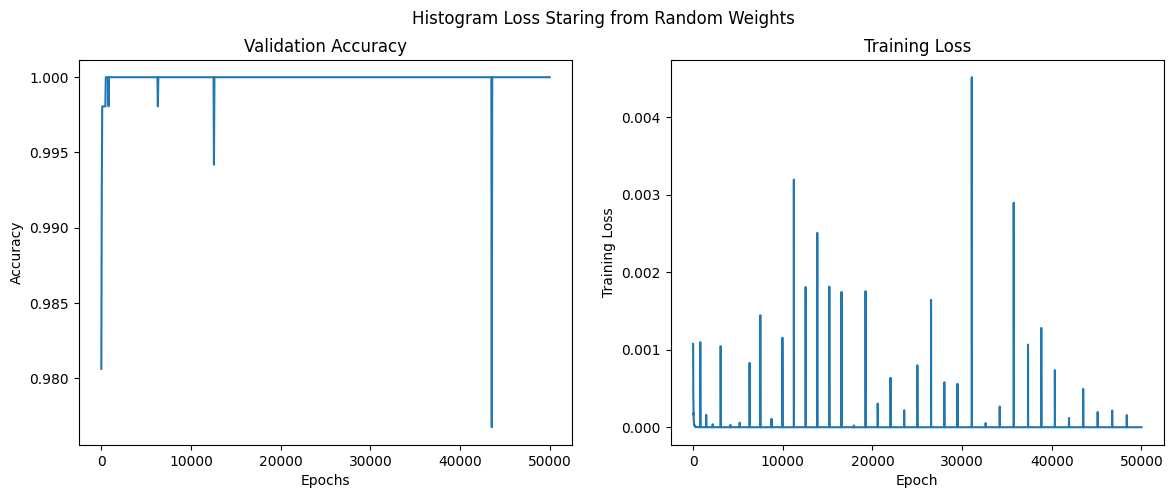

In [174]:
displayResults(title="Histogram Loss Staring from Tracr Model", valName="hist_val_v2", lossName="hist_loss_v2")
displayResults(title="Histogram Loss Staring from Random Weights", valName="random_hist_val_v2", lossName="random_hist_loss_v2")

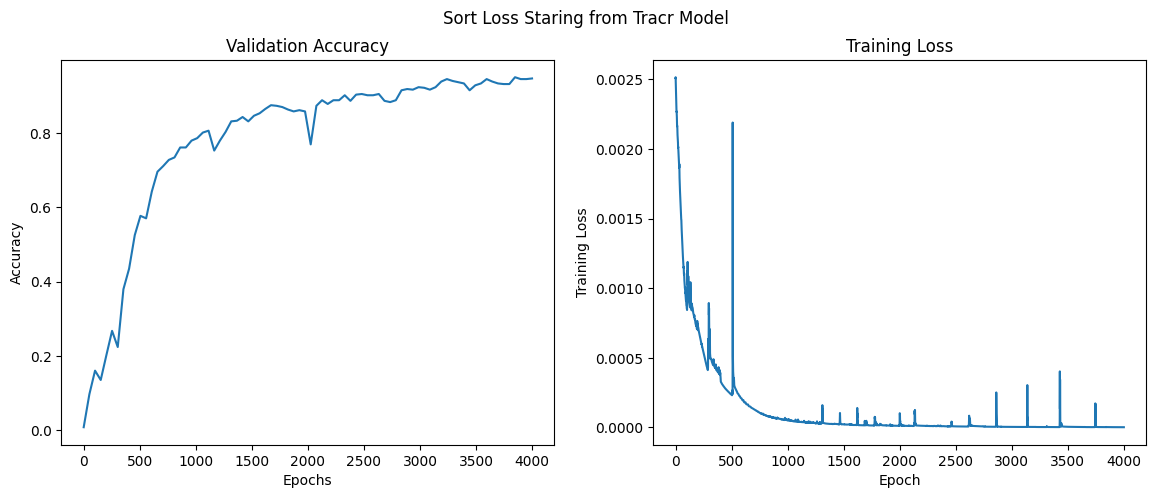

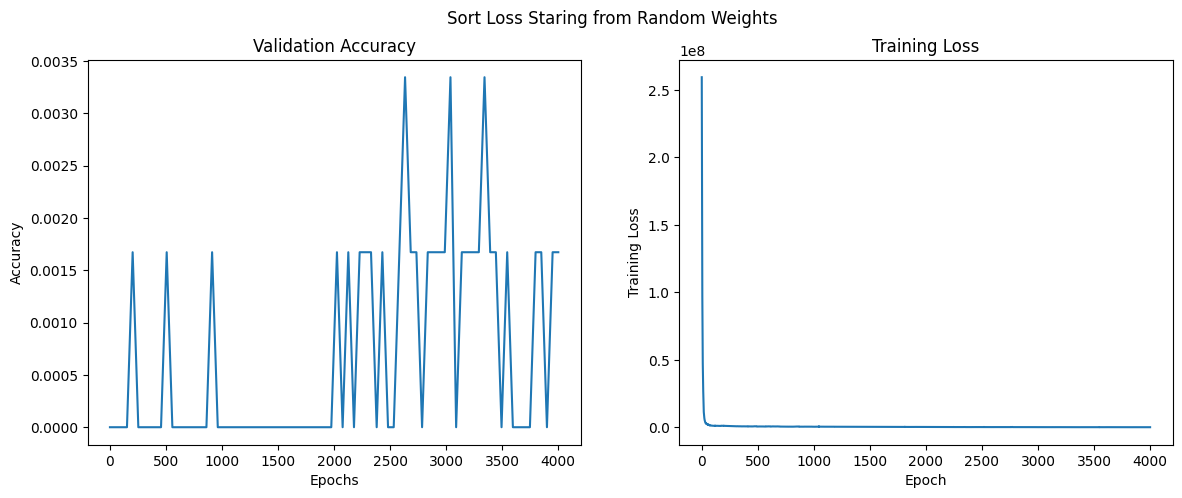

In [185]:
displayResults(title="Sort Loss Staring from Tracr Model", valName="short_sort_val_v2", lossName="short_sort_loss_v2", n_epochs=4000)
displayResults(title="Sort Loss Staring from Random Weights", valName="short_random_sort_val_v2", lossName="short_random_sort_loss_v2", n_epochs=4000)

NOTE

v1 uses max length 5 and v2 uses max length 10